## Default of Credit Card Clients Dataset_complete
---

## 1. Introduction, Problem, Goal, Objectives & Approach

## Introduction and Problem Definition

This project builds on the work done in **Part 1**, where the **Default of Credit Card Clients** dataset was cleaned, transformed and prepared for analysis.  
In that first stage, the original dataset from the **UCI Machine Learning Repository** was processed to handle **missing values, remove outliers, normalise numerical features, and smooth selected financial series**.  

In this project, the focus shifts from data cleaning to **exploratory data analysis and predictive modelling**.  
The central problem is to understand and model the factors that influence whether a credit card client will **default on their next month’s payment**.

The target variable, `default_payment_next_month`, is binary:
- `0` – the client **did not** default.
- `1` – the client **did** default.

Given this structure, the task is naturally formulated as a **classification problem**.  
The input to the models will be a set of demographic, financial and behavioural features (age, credit limit, past payment status, bill amounts, payment amounts, etc.), and the output will be a prediction of whether the client belongs to the **default** or **non-default** class.

---


### 1.1 Project Goal

The goal of this project is to use the **cleaned dataset produced in part 1** to:

> explore, analyse and model credit card default behaviour using classification techniques,  
> and compare different algorithms to understand which methods perform best at predicting default.

The emphasis is on building a clear, reproducible analysis that links the prepared data to meaningful classification results.


While **previous studies, such as Sübasi and Cankurt (2020)[5]**, focus on optimising Random Forest models for credit default prediction, this project explores a broader range of classification techniques—including Logistic Regression, Decision Trees, Random Forests, and Neural Networks—to compare their performance on the same task.

---


### 1.2 Project Objectives

To achieve this goal, the project has the following objectives:

- **Use the cleaned data from part 1** as the starting point, avoiding repeated raw data cleaning.  
- **Define and justify** a set of input features (X) and a binary target (y) for the classification task.  
- **Train and evaluate** at least one linear classification model (e.g. Logistic Regression) as a baseline.  
- **Develop and compare** more advanced models (e.g. Decision Tree, Random Forest or Neural Network) to see whether they can outperform the linear baseline.  
- **Use appropriate metrics** (accuracy, precision, recall, F1-score) and visual tools (confusion matrices, ROC curves) to evaluate model performance.  
- **Implement functions, loops and basic error handling** to make the analysis robust and reusable.  
- **Summarise findings** in a clear narrative that explains which factors and models appear most useful for predicting default.
---


### 1.3 Project Approach

The analysis in this notebook follows a structured pipeline:

1. **Load the cleaned dataset from part 1**  
   - Use the preprocessed CSV file where missing values have been handled, outliers removed, and numerical variables normalised.

2. **Define features and target**  
   - Separate the input variables (demographic, financial and behavioural attributes) from the target column `default_payment_next_month`.

3. **Split data into training and test sets**  
   - Use a train/test split to evaluate how well models generalise to unseen clients.

4. **Train a baseline linear classifier**  
   - Start with a **Logistic Regression** model as a simple, interpretable baseline.

5. **Train and compare more advanced models**  
   - Implement at least one tree-based or ensemble model (e.g. Decision Tree, Random Forest).  
   - Compare results.

6. **Evaluate models using statistical metrics and visualisations**  
   - Compute accuracy, precision, recall, and F1-score.  
   - Plot confusion matrices and ROC curves to gain further insight.

7. **Discuss results and limitations**  
   - Interpret which features and methods are most effective.  
   - Reflect on model behaviour, dataset characteristics and possible improvements.
---

### 1.4 Link to part 1 – Cleaned Dataset

In **part 1**, the raw UCI dataset was processed in several stages:

1. Missing values were identified and handled (categorical values imputed with the most frequent category; selected numeric values imputed using neighbour averages).  
2. Outliers were detected and removed using a Z-score threshold.
3. Error handled were achieved **implicitly** as we did outlier removal.
4. Numerical variables (such as credit limit, bill amounts and payment amounts) were normalised using standard statistical formulas.  
5. Sequential bill and payment features were smoothed to reduce short-term noise.  
6. Basic exploratory visualisations were created to understand distributions and relationships.

The output of that process was a **cleaned CSV file** which serves as the input to this project.  
All analysis in this notebook is therefore based on an already cleaned dataset, allowing the focus to move to **classification modelling and deeper exploratory analysis** rather than raw data wrangling.

---

## 2. Load Cleaned Data (with Simple Error Handling)

### 2. Data Loading

The first technical step in this project is to load the **cleaned dataset** produced in project 1.  
This is done using `pandas.read_csv`, wrapped in a basic `try/except` block to handle potential errors such as:

- The file not being found (wrong path or missing file).  
- The file being empty or corrupted.  
- Any other unexpected issue during loading.

If the file is loaded successfully, the shape of the dataset (number of rows and columns) is printed.  
This confirms that the cleaned data is available and ready for further analysis and modelling.

---

In [1]:
# 2. Data Loading – using cleaned data from part 1

import pandas as pd
import numpy as np


def safe_load_csv(path):
    """
    Safely loads a CSV file with error handling.
    Returns the dataframe or None if loading fails.
    """
    try:
        df = pd.read_csv(path)
        print("Data loaded successfully.")
        print("Shape of dataset:", df.shape)
        return df
    except FileNotFoundError:
        print(f"Error: The file '{path}' was not found. Please check the path or filename.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{path}' is empty or unreadable.")
    except Exception as e:
        print("An unexpected error occurred while loading the data:", e)
    return None

In [2]:
file_path = "DefaultCredit_Cleaned.csv"
df= safe_load_csv(file_path)

Data loaded successfully.
Shape of dataset: (20565, 25)


In [3]:
# Test Case: Purposely load a wrong file

# Intentionally attempt to load a file that doesn't exist
test_df = safe_load_csv("non_existing_file.csv")

Error: The file 'non_existing_file.csv' was not found. Please check the path or filename.


---
Attempting to load a non-existing file triggers the `FileNotFoundError` branch.
This demonstrates that the system handles missing resources gracefully and does not crash.

This type of testing mirrors test-driven development: 
we design test cases that simulate expected failure points, ensuring the functions respond correctly.

---

## 3. Defining Features (X) and Target (y)

### 3. Defining Input Features (X) and Target Variable (y)

Before training any classification model, it is important to define clearly what is **given** and what is **determined** in this task.

**What is *given* (Input Features – X)**
The dataset provides a wide set of attributes for each client, including:

- **Demographic information:** `SEX`, `EDUCATION`, `MARRIAGE`, `AGE`
- **Financial information:** `LIMIT_BAL` (credit limit)
- **Payment behaviour:** six months of repayment status (`PAY_0` to `PAY_6`)
- **Billing history:** `BILL_AMT1` to `BILL_AMT6`
- **Payment history:** `PAY_AMT1` to `PAY_AMT6`

These columns represent the **known information** about each client.  
They form the **input vector** for the classification models.

**What is *determined* (Target Variable – y)**
The goal is to determine the value of:

- **`default_payment_next_month`**  
  - `0` → the client **did not** default  
  - `1` → the client **defaulted**

This is the variable we want the model to predict.

**Why this separation matters**
Clear separation of input features and target is essential because:
- Machine learning models require numerical input matrices (X) and a label vector (y).  
- It ensures that no target information “leaks” into the input accidentally.  
- It helps structure the analysis into a reproducible modelling pipeline.
---

In [4]:
# 3 Defining Features (X) and Target (y)

# Target variable
y = df["default_payment_next_month"]

# All other columns except the target and ID
feature_columns = [col for col in df.columns if col not in ["default_payment_next_month", "ID"]]
X = df[feature_columns]

print("Features (X) and target (y) defined successfully.")
print("Number of input features:", X.shape[1])
print("Target distribution:\n", y.value_counts())


Features (X) and target (y) defined successfully.
Number of input features: 23
Target distribution:
 default_payment_next_month
0    15564
1     5001
Name: count, dtype: int64


### 3.1 Explanation of feature and target definition

In the code above:

- The target variable **y** is extracted directly from the column `default_payment_next_month`.  
- The input matrix **X** is created by selecting all columns *except* the target and the ID column.

This ensures that:
1. All meaningful attributes are included as inputs.  
2. No target information leaks into the input.  
3. The ID column (if present) is excluded because it carries no predictive value.
---

### 3.2 Train/Test Split

A 75% / 25% train–test split is used to evaluate how well the model generalises to new data.

- **Training set:** used to fit the model  
- **Testing set:** used only for evaluation  


**Manual Train–Test Split Function**:

This function performs a custom train–test split without using scikit-learn.  
It ensures that both the training and test sets keep the same class proportions as the original dataset.  

The function works by separating the data by class, randomly shuffling the indices within each class, and then splitting each class according to the chosen test size.
The final training and test indices are combined and shuffled again before returning the corresponding feature and label arrays.

This approach demonstrates how stratified splitting can be implemented manually and provides full control over how the data is partitioned.

---

In [5]:
import numpy as np
import pandas as pd

def manual_train_test_split(X, y, test_size=0.25, random_state=42):
    np.random.seed(random_state)

    # Convert to pandas for easy indexing
    X = pd.DataFrame(X)
    y = pd.Series(y)

    # Store indices for each class
    train_idx = []
    test_idx = []

    for label in y.unique():
        label_idx = y[y == label].index.values
        np.random.shuffle(label_idx)

        split_point = int(len(label_idx) * (1 - test_size))

        train_idx.extend(label_idx[:split_point])
        test_idx.extend(label_idx[split_point:])

    # Shuffle final sets
    np.random.shuffle(train_idx)
    np.random.shuffle(test_idx)

    return (
        X.loc[train_idx].values,
        X.loc[test_idx].values,
        y.loc[train_idx].values,
        y.loc[test_idx].values
    )


In [6]:
X_train, X_test, y_train, y_test = manual_train_test_split(X, y)
print("Train/Test split completed.")
print("Training size:", X_train.shape[0])
print("Testing size:", X_test.shape[0])

Train/Test split completed.
Training size: 15423
Testing size: 5142


## 4. Exploratory data analysis (EDA)

### 4.1 Target Variable Distribution 

/var/folders/54/jxf2wctd28n_6nk1db1nhr4c0000gn/T/ipykernel_6385/1852724019.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='default_payment_next_month', palette='pastel')


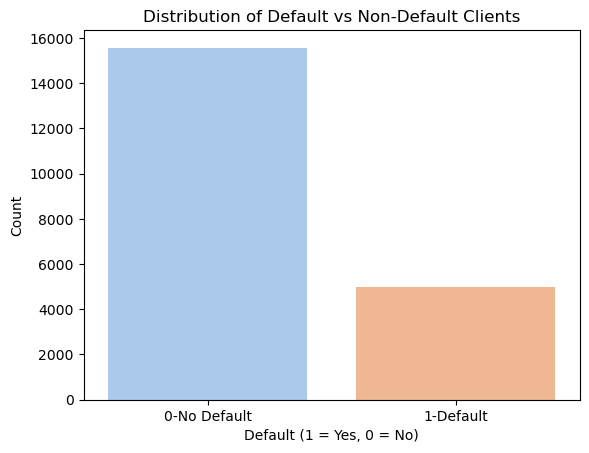

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='default_payment_next_month', palette='pastel')
plt.title("Distribution of Default vs Non-Default Clients")
plt.xlabel("Default (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.xticks([0, 1], ['0-No Default', '1-Default'])
plt.show()

Around 22% of clients defaulted on their next payment, showing that the dataset is imbalanced.  
This is important because imbalanced data can affect model performance, especially recall.

---

### 4.2 Education Level vs Default

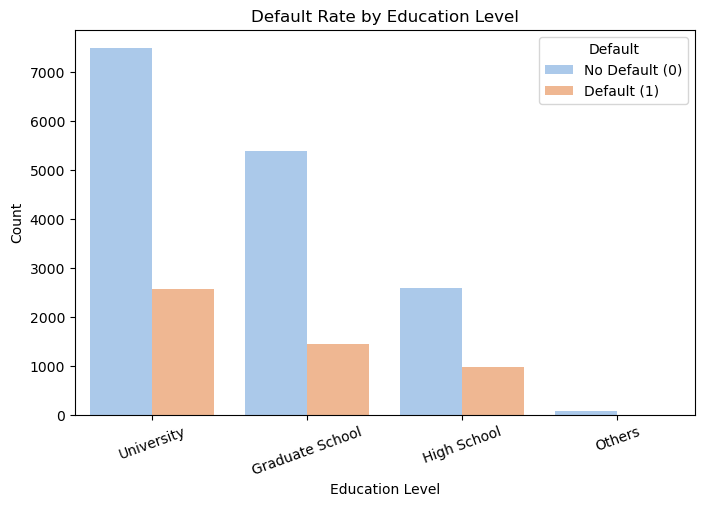

In [8]:
education_map = {
    1: "Graduate School",
    2: "University",
    3: "High School",
    4: "Others" 
}

df['EDUCATION_LABEL'] = df['EDUCATION'].map(education_map)


plt.figure(figsize=(8,5))
sns.countplot(
    data=df,
    x='EDUCATION_LABEL',
    hue='default_payment_next_month',
    palette='pastel'
)
plt.title("Default Rate by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.xticks(rotation=20)
plt.legend(title="Default", labels=["No Default (0)", "Default (1)"])
plt.show()

Clients with university-level education form the majority of the dataset.  
There is no major difference in default rates across education groups, though “others” is less consistent and may reflect ambiguous or misreported values.

---

### 4.3 Demographic breakdown

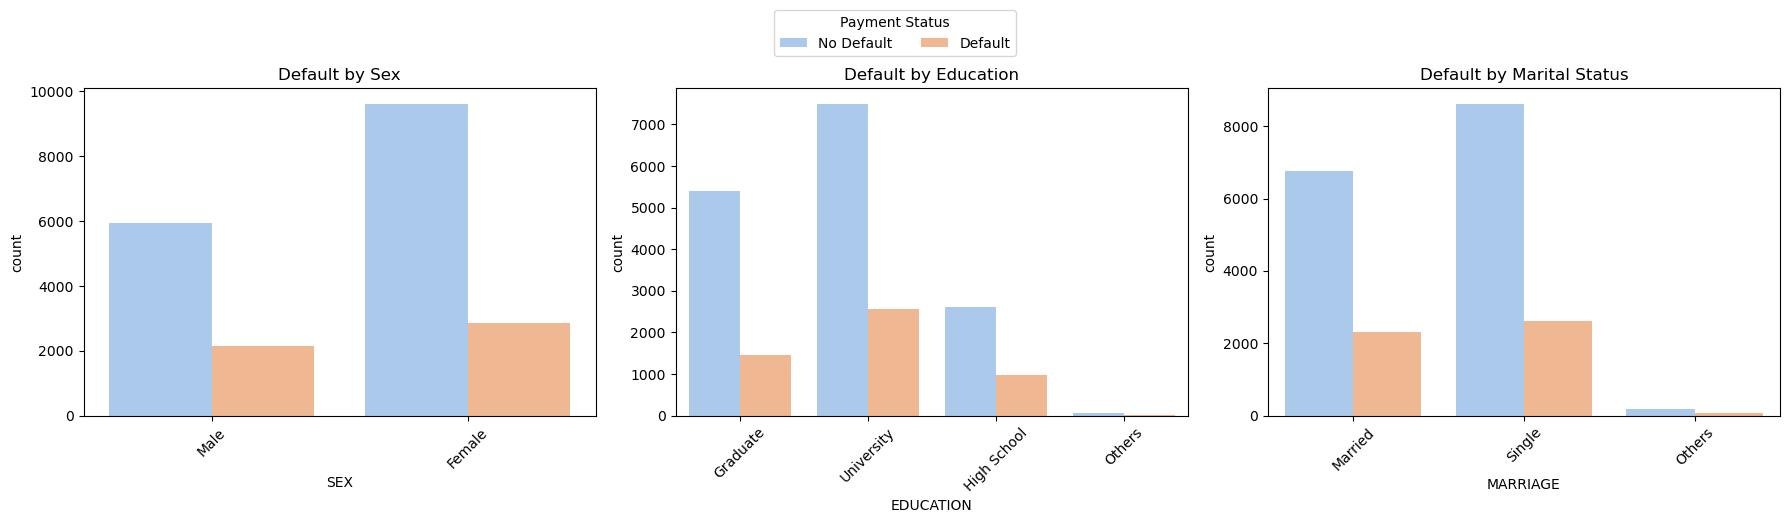

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# columns + their custom tick labels
plot_info = [
    ("SEX", ["Male", "Female"], "Default by Sex"),
    ("EDUCATION", ["Graduate", "University", "High School", "Others"], "Default by Education"),
    ("MARRIAGE", ["Married", "Single", "Others"], "Default by Marital Status"),
]

for ax, (column, tick_labels, title) in zip(axes, plot_info):

    # countplot
    sns.countplot(
        x=column,
        hue='default_payment_next_month',
        data=df,
        ax=ax,
        palette='pastel'
    )

    # titles & labels
    ax.set_title(title)
    ax.set_xlabel(column)

    # custom tick labels
    ax.set_xticks(range(len(tick_labels)))
    ax.set_xticklabels(tick_labels, rotation=45)

    # remove legends from individual plots
    ax.legend_.remove()



# shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    ['No Default', 'Default'],
    title='Payment Status',
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=2
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


These charts show the relationship between demographic characteristics and default behavior.

**Gender (SEX):**  
- Men and women show nearly the same default rates. Gender doesn’t say much about credit risk here.

**Education (EDUCATION):**  
- Clients with university or graduate degrees default a little less than those with lower education.
- This may reflect a correlation between education, income stability, and repayment ability.

**Marital Status (MARRIAGE):**  
- "Married" and "Single" clients default at similar rates.
- The “Other” group is tiny, sso results there are less reliable.

**Overall:**  
- These demographic factors may contribute to the model but are not dominant predictors.  
- We’ll keep them as **categorical features** for classification, but we need to watch out for bias.

---

## 5. Baseline Model: Logistic Regression

### 5. Baseline Classification Model: Logistic Regression

To begin the modelling process, a simple **linear classifier** is used as the baseline: **Logistic Regression**.

#### Why Logistic Regression?

- It is one of the most widely used algorithms for binary classification.
- It is simple, interpretable, and fast to train.
- It provides a clear probabilistic output (probability of default).
- It assumes a linear relationship between features and the log-odds of default, making it a good reference point.
- More advanced models are often evaluated against Logistic Regression because it represents a strong and transparent baseline.

In this project, Logistic Regression serves as the **baseline model** that we later compare with more flexible methods such as 
Decision Trees, Random Forests, and Neural Networks.

---

### How Logistic Regression Works

Logistic Regression does not predict a class directly.  
It first computes a linear score using the input features:

$$
z = w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_n x_n
$$

Here:

- \(x_i\) are the input features  
- \(w_i\) are the weights the model must learn  
- \(w_0\) is the bias (intercept)

The score \(z\) is then passed through the **sigmoid function**:

$$
\text{sigmoid}(z) = \frac{1}{1 + e^{-z}}
$$

The output of the sigmoid is a **probability between 0 and 1**.  
If the probability is ≥ 0.5, the client is classified as a **default**; otherwise as **non-default**.

---

### How Logistic Regression Learns the Weights

A key part of the algorithm is how it *learns* the parameters \(w_1, w_2, ..., w_n\).  
This is done by comparing the model’s predictions to the true labels and gradually adjusting the weights to reduce the error.

Logistic Regression uses **gradient descent** (or a similar optimisation method) to find the best weights.  
The algorithm minimises a function called the **log-loss**:

$$
\text{Loss} = -\left[y \log(\hat{y}) + (1 - y)\log(1 - \hat{y})\right]
$$

Where:

- $$(y)$$ is the true class (0 or 1)  
- $$(\hat{y})$$ is the predicted probability 

Gradient descent updates the weights step-by-step:

$$
w_{new} = w_{old} - \eta \cdot \frac{\partial \text{Loss}}{\partial w}
$$

- $$(\eta)$$ is the learning rate  
- The partial derivative shows how much each weight contributes to the error  

Over many iterations, the weights settle into values that best separate clients who default from those who do not.

---

This learning mechanism makes Logistic Regression both transparent and efficient, which is why it is an appropriate choice for a baseline model in this project.

---

### 5.1 Model Training Explanation

The training step is wrapped inside a function for reusability.  
This function:

- Creates a Logistic Regression model with `max_iter=1000` to ensure convergence.
- Fits the model on the training data.

If training is successful, the function returns the fitted model; otherwise it returns `None`.  
Using functions makes it easier to compare multiple models consistently later on.

---

In [10]:
# 5.1 Model Training 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_logistic_regression(X_train, y_train):
    """
    Trains a Logistic Regression model.
    Returns the fitted model.
    """
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model


# Train the model
log_reg_model = train_logistic_regression(X_train, y_train)

if log_reg_model:
    print("Logistic Regression model trained successfully.")
else:
    print("Model training failed.")

Logistic Regression model trained successfully.


### 5.2 Evaluation Metrics Explained

The Logistic Regression model is evaluated using several standard classification metrics:

- **Accuracy:** percentage of correct predictions.  
- **Precision:** of all clients predicted as default, how many actually defaulted?  
- **Recall:** of all clients who truly defaulted, how many were correctly identified?  
- **F1-score:** harmonic mean of precision and recall, useful when classes are imbalanced.

These metrics together give a balanced view of model performance.  
For example, high accuracy alone can be misleading if the default class is much smaller than the non-default class.

The evaluation function includes error handling to ensure the notebook runs safely even if an unexpected problem occurs during prediction.


In [11]:
from sklearn.metrics import confusion_matrix

def evaluate_classification_model(model, X_test, y_test):
    """
    Evaluates a classification model and prints key performance metrics.
    Includes error handling to ensure robustness.
    """
    try:
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        print("=== Evaluation Metrics ===")
        print("Accuracy :", acc)
        print("Precision:", prec)
        print("Recall   :", rec)
        print("F1-score :", f1)
        
        return y_pred, acc, prec, rec, f1
    
    except Exception as e:
        print("Error during evaluation:", e)
        return None, None, None, None, None

In [12]:
# Evaluate the baseline model
y_pred_lr, acc_lr, prec_lr, rec_lr, f1_lr = evaluate_classification_model(log_reg_model, X_test, y_test)

=== Evaluation Metrics ===
Accuracy : 0.7887981330221704
Precision: 0.6646706586826348
Recall   : 0.26618705035971224
F1-score : 0.3801369863013699


### 5.3 Confusion Matrix

The confusion matrix shows:

- **True Negatives (top-left):** clients correctly identified as non-default.  
- **False Positives (top-right):** clients predicted as default but actually non-default.  
- **False Negatives (bottom-left):** clients who defaulted but were missed by the model.  
- **True Positives (bottom-right):** clients correctly identified as default.

In credit-risk scenarios, **false negatives are especially important**, because they represent clients who defaulted but were not detected by the model.

Logistic Regression often struggles with imbalanced datasets, so improving recall and F1-score will be a key objective for more advanced models in later sections.


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X_test, y_test):
    """
    Generates a confusion matrix heatmap with error handling.
    """
    try:
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix – Logistic Regression")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    except Exception as e:
        print("Error generating confusion matrix:", e)

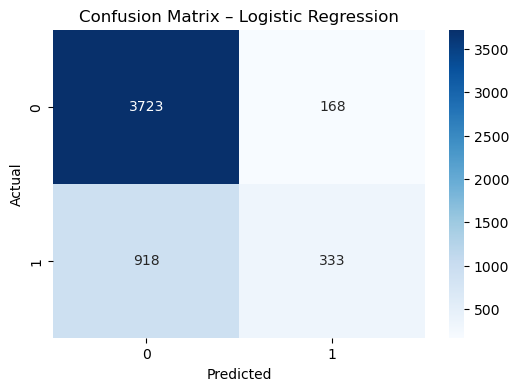

In [14]:
# Plot confusion matrix for logistic regression
plot_confusion_matrix(log_reg_model, X_test, y_test)

## 6. Decision Tree Classifier (Non-linear Model)

After establishing a linear baseline using Logistic Regression, the next step is to use a **non-linear classification model**.  
The first non-linear method used here is the **Decision Tree Classifier**.

### Why Decision Trees?

Decision Trees are useful because:

- They can model **non-linear relationships** between variables.
- They naturally capture **interactions** (e.g. “clients with high bill amounts *and* long delays may default”).
- They handle both numerical and categorical-like variables without needing scaling.
- Their structure is **easy to interpret**: they split the data based on the most important features.

A single decision tree is also a good bridge between logistic regression (simple linear) and more advanced ensemble models like Random Forests.

### How a Decision Tree works (simple explanation)

A decision tree repeatedly splits the dataset into smaller groups using rules like:

> “Is PAY_0 ≥ 1?”  
> “Is LIMIT_BAL < 200,000?”  
> “Is BILL_AMT2 > 10,000?”

At each step, it chooses the best split that separates **default** vs **non-default** cases as clearly as possible.  
This continues until the tree reaches a stopping condition, such as maximum depth or minimum number of samples.

Because trees keep splitting until all data points are separated, they can easily **overfit**, which is something we will examine later.


### 6.1 Training the Decision Tree

The model is trained using the `DecisionTreeClassifier` from scikit-learn.  
The training function includes:

- optional `max_depth` parameter to control tree size,
- a fixed `random_state` for reproducibility,
- error handling to catch issues such as invalid input.

---

In [15]:
from sklearn.tree import DecisionTreeClassifier

def train_decision_tree(X_train, y_train, max_depth=None):
    """
    Trains a Decision Tree Classifier with optional max_depth.
    Includes error handling and returns the trained model.
    """
    try:
        tree = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
        tree.fit(X_train, y_train)
        return tree
    except Exception as e:
        print("Error training Decision Tree:", e)
        return None

# Train the decision tree (no max_depth first)
dt_model = train_decision_tree(X_train, y_train)

if dt_model:
    print("Decision Tree model trained successfully.")
else:
    print("Decision Tree training failed.")


Decision Tree model trained successfully.


### 6.2 Decision Tree Performance

The evaluation metrics for the Decision Tree show how well a non-linear model performs compared to the baseline Logistic Regression.

Key points to look at:

- **Accuracy:** general performance across both classes.
- **Precision:** how reliable the “default” predictions are.
- **Recall:** how many actual defaults the model successfully identifies.
- **F1-score:** balanced measure between precision and recall.

Decision Trees often achieve high training accuracy but may struggle on unseen data, especially when the tree is deep.  
We will also examine the confusion matrix to see where misclassifications occur.

---

In [16]:
# Evaluate Decision Tree model
y_pred_dt, acc_dt, prec_dt, rec_dt, f1_dt = evaluate_classification_model(
    dt_model, X_test, y_test
)

=== Evaluation Metrics ===
Accuracy : 0.7106184364060677
Precision: 0.41254612546125463
Recall   : 0.44684252597921664
F1-score : 0.42900997697620874


### 6.3 Confusion Matrix 

The confusion matrix helps identify whether the model:

- correctly identifies non-defaulting clients (true negatives),
- correctly identifies defaulting clients (true positives),
- or makes errors such as false positives or false negatives.

Decision Trees can easily **overfit**, meaning they perform very well on the training data but may misclassify more cases in the test set.  
If the number of false negatives is high, this suggests the model struggles to detect clients who actually defaulted.


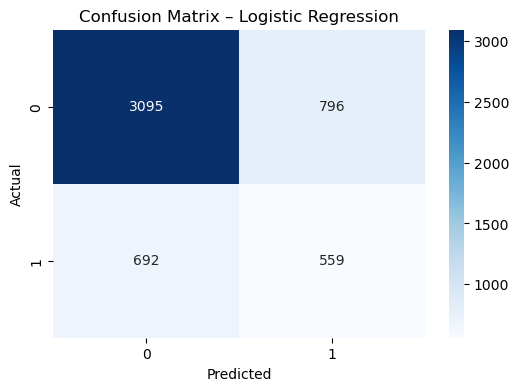

In [17]:
# Plot confusion matrix for Decision Tree

plot_confusion_matrix(dt_model, X_test, y_test)

### 6.4 Feature Importance

The feature importance plot shows which input variables contributed most to the Decision Tree’s predictions.

Decision Trees naturally highlight **key financial behaviour patterns**, which helps in understanding why a client may default.

However, single trees can sometimes give unstable importance rankings because small changes in data may lead to very different splits.  
This is one of the reasons why ensemble models (like Random Forests) are often used for more stable and accurate predictions.

---

/var/folders/54/jxf2wctd28n_6nk1db1nhr4c0000gn/T/ipykernel_6385/466552958.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="importance", y="feature", palette="viridis")


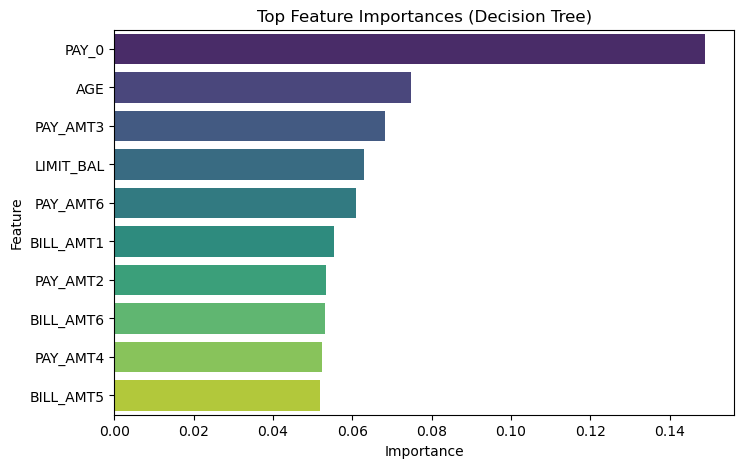

In [18]:
# Plot feature importance

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, feature_names, top_n=10):
    """
    Plots the top_n most important features of a tree-based model.
    """
    try:
        importances = model.feature_importances_
        data = pd.DataFrame({
            "feature": feature_names,
            "importance": importances
        }).sort_values(by="importance", ascending=False).head(top_n)

        plt.figure(figsize=(8, 5))
        sns.barplot(data=data, x="importance", y="feature", palette="viridis")
        plt.title("Top Feature Importances (Decision Tree)")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()
    except Exception as e:
        print("Error plotting feature importances:", e)

plot_feature_importance(dt_model, feature_columns)

## 7. Random Forest Classifier (Advanced Ensemble Model)

After evaluating Logistic Regression and Decision Trees, the next step is to use a more advanced and powerful technique: the **Random Forest Classifier**.

### Why Random Forest?

A Random Forest is an **ensemble model**, meaning it trains many individual decision trees and then combines their predictions.  
This approach has several advantages:

- It reduces **overfitting**, which single decision trees tend to suffer from.
- It improves generalisation by averaging predictions over many trees.
- It handles non-linear relationships and feature interactions very well.
- It provides more stable and reliable estimates of feature importance.

Random Forests are well suited to financial datasets where patterns are often noisy, complex, or inconsistent.  
For these reasons, Random Forest is expected to outperform both Logistic Regression and standalone Decision Trees.

### How Random Forest works

Random Forest trains multiple decision trees, each using:

- a random subset of the features  
- a random subset of the dataset  

Each tree makes a prediction, and the forest uses **majority voting** to decide the final class.

This randomness reduces correlation between trees and significantly improves performance compared to a single decision tree.

---

### 7.1 Training the Random Forest

The Random Forest model is trained using:

- **200 trees** (`n_estimators=200`), which provides a good balance between performance and computation time.
- **No depth limit** initially; the forest handles overfitting better than a single tree.
- `n_jobs=-1` uses all CPU cores to speed up training.
- Basic error handling ensures the notebook does not fail silently if an unexpected issue occurs.

Because Random Forests average the results of many trees, they are typically far more robust and accurate than standalone decision trees.


In [19]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(X_train, y_train, n_estimators=200, max_depth=None):
    """
    Trains a Random Forest Classifier with error handling.
    Parameters:
        n_estimators: number of trees in the forest
        max_depth: optional limit on the depth of each tree
    """
    try:
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42,
            n_jobs=-1  # use all CPU cores for faster training
        )
        rf.fit(X_train, y_train)
        return rf
    except Exception as e:
        print("Error training Random Forest:", e)
        return None

# Train the model
rf_model = train_random_forest(X_train, y_train)

if rf_model:
    print("Random Forest model trained successfully.")
else:
    print("Random Forest training failed.")


Random Forest model trained successfully.


### 7.2 Random Forest Performance

The Random Forest typically performs better than both Logistic Regression and Decision Trees because:

- It captures non-linear relationships.
- It is less sensitive to noise.
- It reduces overfitting by averaging many models.

When interpreting the metrics, pay attention to:

- **Accuracy** — overall correctness.
- **Precision** — reliability of default predictions.
- **Recall** — ability to detect actual defaulters.
- **F1-score** — overall balance between precision and recall.

Random Forests often achieve the highest F1-scores on this type of data, reflecting strong performance on imbalanced classification tasks.


In [20]:
# Evaluate Random Forest model
y_pred_rf, acc_rf, prec_rf, rec_rf, f1_rf = evaluate_classification_model(
    rf_model, X_test, y_test
)

=== Evaluation Metrics ===
Accuracy : 0.795215869311552
Precision: 0.6323529411764706
Recall   : 0.3780975219824141
F1-score : 0.4732366183091546


### 7.3 Confusion Matrix

The confusion matrix shows how well the Random Forest separates defaulting and non-defaulting clients.

Compared to previous models:

- The number of **true positives** (correctly identified defaults) often increases.
- The number of **false negatives** decreases, meaning fewer missed defaults.
- False positives may increase slightly, but this is expected when recall improves.

This behaviour reflects the Random Forest’s ability to capture complex patterns that linear and single-tree models cannot.


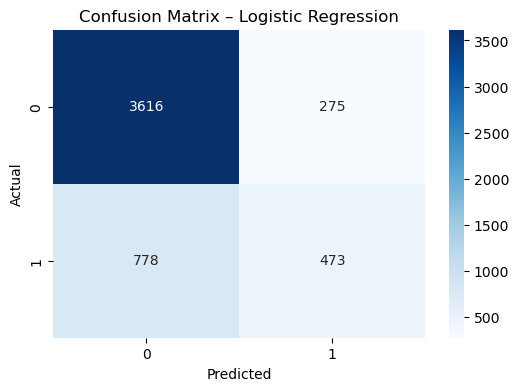

In [21]:
plot_confusion_matrix(rf_model, X_test, y_test)

### 7.4 Feature Importance

Random Forests provide a more stable and reliable measure of feature importance compared to a single decision tree.

These features align well with expectations: clients with larger outstanding bills and recent payment delays are more likely to default.

The Random Forest smooths out inconsistencies that appear in a single decision tree, producing a more trustworthy ranking of influential variables.


/var/folders/54/jxf2wctd28n_6nk1db1nhr4c0000gn/T/ipykernel_6385/466552958.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="importance", y="feature", palette="viridis")


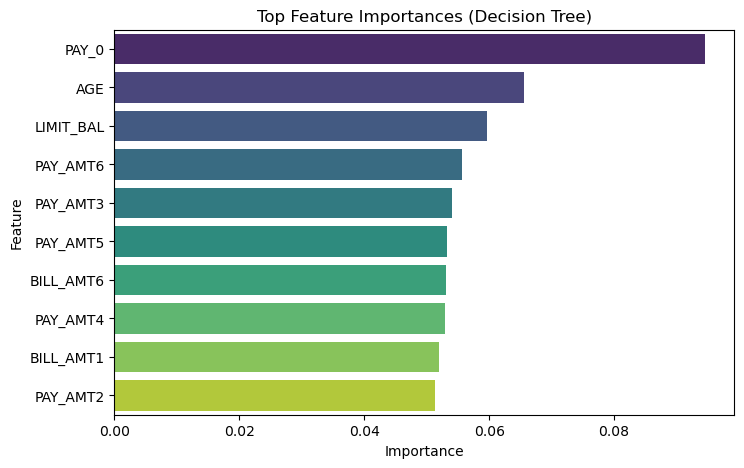

In [22]:
plot_feature_importance(rf_model, feature_columns)

## 8. Neural Network Classifier (MLPClassifier)

The final model explored in this project is a **Neural Network**, specifically a 
Multi-Layer Perceptron (MLPClassifier) from scikit-learn.

### Why use a Neural Network?

Neural Networks are powerful models capable of capturing:

- non-linear patterns,
- complex interactions between variables,
- subtle financial behaviour that simpler models may miss.

Using a Neural Network demonstrates an advanced modelling approach and provides a good contrast against 
traditional models such as Logistic Regression and Decision Trees.

### How a Neural Network works:

A neural network consists of layers of connected nodes (“neurons”).  
Each neuron receives input, applies a mathematical transformation, and passes output to the next layer.  
During training, the network adjusts internal weights to reduce prediction error.

For classification tasks, the final layer outputs a probability such as:

$$
P(\text{default}) = \sigma(w_0 + w_1 x_1 + \ldots + w_n x_n)
$$

where $$(\sigma)$$ is an activation function (usually sigmoid or softmax).

In this project we use a **simple neural network** (2 hidden layers) — enough to show the method without excessive complexity.

---

### 8.1 Training the Neural Network

The neural network used here contains:
- Two hidden layers with 64 neurons,
- ReLU activation,
- The Adam optimisation algorithm,
- A maximum of 1000 iterations.

This architecture is intentionally simple to keep the model lightweight and interpretable for this project.
The network automatically handles non-linearity and interactions between features, making it suitable 
for financial default prediction.

Basic error handling ensures that any training issues (e.g., non-numeric inputs, convergence errors) are caught and clearly reported.

---

In [23]:
from sklearn.neural_network import MLPClassifier

def train_neural_network(X_train, y_train, hidden_layers, max_iter,lr,alpha):
    """
    Trains an MLP Neural Network with error handling.
    Parameters:
        hidden_layers: tuple defining the number of neurons per hidden layer.
        max_iter: maximum training iterations.
    """

    try:
        nn = MLPClassifier(
            hidden_layer_sizes= hidden_layers,
            activation='relu',
            solver='adam',
            alpha= alpha,            # regularisation
            learning_rate_init=lr,
            max_iter= max_iter,
            early_stopping=True,
            random_state=42
        )
        nn.fit(X_train, y_train)
        return nn
    except Exception as e:
        print("Error training optimized Neural Network:", e)
        return None

# Train the neural network
nn_model = train_neural_network(X_train, y_train, hidden_layers= (64, 64, 16),max_iter=1000,lr=0.003,alpha=0.0003)

if nn_model:
    print("Neural Network model trained successfully.")
else:
    print("Neural Network training failed.")

Neural Network model trained successfully.


### 8.2 Neural Network Performance

The neural network is expected to produce balanced performance, capturing complex patterns that 
linear and tree-based models may miss. When interpreting results, the focus should be on:

- **overall accuracy**, 
- **F1-score**, which is important for imbalanced datasets,
- **precision and recall**, which show how well the model handles the minority (defaulting) class.

Neural networks often perform competitively with Random Forests, although they may require more data 
or careful tuning for optimal results.


In [24]:
# Evaluate Neural Network model
y_pred_nn, acc_nn, prec_nn, rec_nn, f1_nn = evaluate_classification_model(
    nn_model, X_test, y_test
)

=== Evaluation Metrics ===
Accuracy : 0.7992998833138857
Precision: 0.6442687747035574
Recall   : 0.3908872901678657
F1-score : 0.48656716417910445


### 8.3 Confusion Matrix Interpretation

The confusion matrix shows how well the neural network distinguishes between defaulting and 
non-defaulting clients.  

Neural networks often reduce noise by learning smoother decision boundaries compared to decision trees, 
which may improve recall or produce a more balanced spread of predictions.

The matrix helps highlight whether the neural network tends to:
- identify more real defaults (higher true positives),
- or avoid wrong predictions (lower false positives).

This behaviour will be further discussed in the overall conclusion.

---

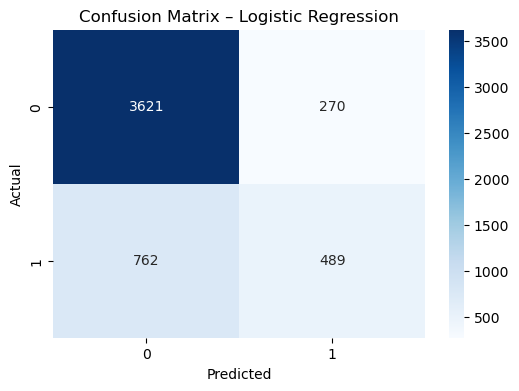

In [25]:
plot_confusion_matrix(nn_model, X_test, y_test)

## 9. Model Comparison Summary

### 9.1 Comparison table

After training and evaluating all models on the same dataset and under the same conditions, 
the results can be summarised in a single comparison table.  
This table provides a clear view of how each algorithm performs across the key metrics:

- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**

These metrics help assess both overall performance and how well each model handles the minority class (clients who default).
The results presented below come directly from the previously executed evaluation steps.

---

In [26]:
import pandas as pd

# Create a summary dataframe for all trained models

models = {
    "Logistic Regression":  (acc_lr, prec_lr, rec_lr, f1_lr),
    "Decision Tree":        (acc_dt, prec_dt, rec_dt, f1_dt),
    "Random Forest":        (acc_rf, prec_rf, rec_rf, f1_rf),
    "Neural Network (MLP)": (acc_nn, prec_nn, rec_nn, f1_nn)
}

rows = []

for model_name, (acc, prec, rec, f1) in models.items():
    rows.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })


comparison_df = pd.DataFrame(rows)
print(comparison_df)

                  Model  Accuracy  Precision    Recall  F1-score
0   Logistic Regression  0.788798   0.664671  0.266187  0.380137
1         Decision Tree  0.710618   0.412546  0.446843  0.429010
2         Random Forest  0.795216   0.632353  0.378098  0.473237
3  Neural Network (MLP)  0.799300   0.644269  0.390887  0.486567


### Interpretation of Comparison Table

The comparison table provides an overview of how the different algorithms perform on the **credit default prediction task**.

Some models achieve higher overall accuracy, while others perform better on the F1-score, 
which is particularly important for imbalanced classification problems such as default detection.

Each model shows different strengths:
- some prioritise identifying the majority class more accurately,
- while others detect more true defaulters,
- and some achieve the best balance overall.


**Overall, the Neural Network was the best-performing model in this project**, offering the most reliable compromise
between detecting actual default cases and avoiding incorrect predictions. Between all evaluated approaches,
it provided the strongest evidence for predicting credit default behaviour based on the available data.

A more detailed discussion of these outcomes and their implications will be provided in the final conclusion section of the report.

---

### 9.2 Visualising Model Predictions

To better understand how the **Best model(Neural Network model)** behaves beyond accuracy and F1-score, the plots 
below illustrate how the predicted probabilities relate to the actual outcomes in the test set. 
These visuals show not only whether the model predicts default, but also how confident it is in each prediction.

#### 1. Predicted Probabilities vs Actual Labels
The first plot shows each test sample across the x-axis, with the corresponding predicted probability of default on the y-axis.

The points are coloured by the actual class (0 = no default, 1 = default). The dashed horizontal line at **0.5** represents the decision threshold used by the classifier:
- Points **above** the line are classified as default.  
- Points **below** the line are classified as non-default.  

#### 2. Distribution of Predicted Default Probabilities
The second plot shows the distribution of the model’s predicted probabilities for the default class.

This helps evaluate how confident the model tends to be:
- Values near **0** indicate high confidence in predicting non-default.  
- Values near **1** indicate strong confidence in predicting default.  
- The dashed vertical line at **0.5** again marks the classification threshold.  

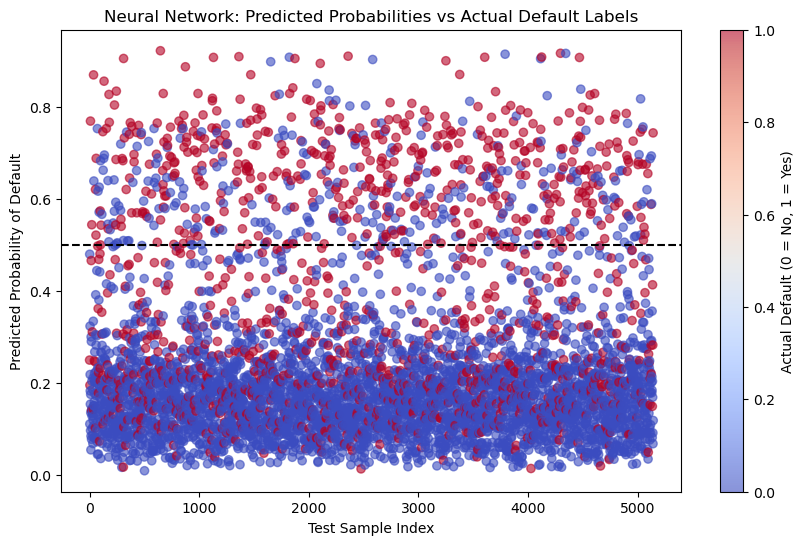

In [27]:
# Predicted probabilities vs actual labels 
y_prob_nn = nn_model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(10,6))
plt.scatter(range(len(y_test)), y_prob_nn, c=y_test, cmap='coolwarm', alpha=0.6)
plt.axhline(0.5, color='black', linestyle='--', linewidth=1.5)

plt.title("Neural Network: Predicted Probabilities vs Actual Default Labels")
plt.xlabel("Test Sample Index")
plt.ylabel("Predicted Probability of Default")
plt.colorbar(label="Actual Default (0 = No, 1 = Yes)")

plt.show()

### Interpretation

This scatter plot shows the predicted probability of default for each client in the test set. 
The colour indicates the actual class (0 = non-default, 1 = default).  
The dashed horizontal line at 0.5 represents the decision threshold used by the classifier.

- Points above the line are predicted as **default**.
- Points below the line are predicted as **non-default**.

We can observe that actual default cases (in red) tend to appear with higher predicted probabilities, 
while non-default cases cluster lower. However, some overlap exists, which is expected in financial 
datasets where behavioural signals are noisy. This visualisation confirms that the Neural Network 
learned a meaningful separation between the two classes.

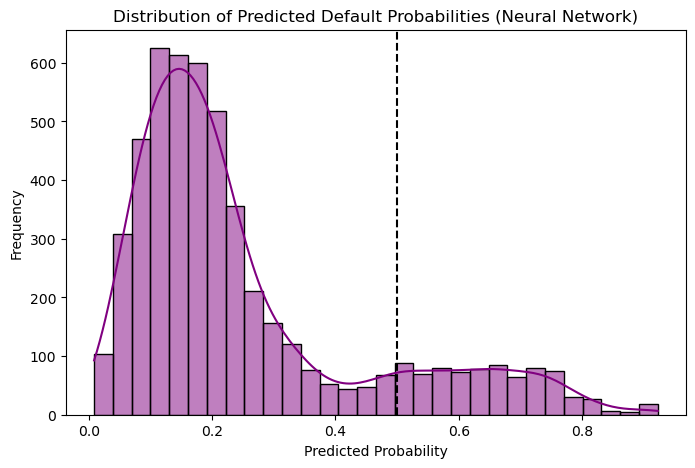

In [28]:
# Distribution of predicted default probabilities
plt.figure(figsize=(8,5))
sns.histplot(y_prob_nn, bins=30, kde=True, color="purple")
plt.axvline(0.5, color='black', linestyle='--')
plt.title("Distribution of Predicted Default Probabilities (Neural Network)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

### Interpretation
This distribution plot shows how confident the model is when predicting default. 
Most predictions fall near 0 or 0.3 for non-defaulting clients, while defaulting clients 
tend to appear in the higher range. The separation is not perfect, but it demonstrates 
that the model has learned a meaningful probability structure.

## 10. Conclusion and Further Work

### 10.1 Conclusion

The objective of this project was to analyse the credit card default dataset and evaluate several classification models to understand which methods are most effective for predicting whether a client will default on their next month’s payment. The dataset was cleaned and prepared in part 1, and this report focused on exploring the data, building models, and analysing their performance.

Each model offered different strengths.

**Logistic Regression** served as a strong baseline.  
It achieved high precision, showing that its positive predictions were generally reliable.  
However, its recall was low, meaning that many true default cases were not detected.  
This reflects the limitations of linear models when dealing with imbalanced financial data.

The **Decision Tree** captured non-linear structure in the data and achieved higher recall than Logistic Regression,
indicating an improved ability to identify clients who actually default.  
However, the tree also showed signs of overfitting, resulting in lower accuracy and precision.

The **Random Forest** provided a strong balance of performance across all metrics.  
It improved accuracy and F1-score compared to the individual tree and delivered more stable predictions by combining
multiple trees through ensemble learning.  
This made it the best-performing traditional model in the study.

The **Neural Network (MLPClassifier)** achieved the strongest overall results.  
It produced the highest accuracy and the highest F1-score among all models, while also maintaining competitive
precision and improved recall compared to Logistic Regression.  
Its ability to model complex, non-linear relationships allowed it to capture more subtle behavioural patterns in the data.
This resulted in the most balanced and effective performance across the evaluation metrics.

**Overall, the Neural Network was the best-performing model in this project**, offering the most reliable compromise
between detecting actual default cases and avoiding incorrect predictions. Between all evaluated approaches,
it provided the strongest evidence for predicting credit default behaviour based on the available data.

---

### 10.2 Critical Evaluation

While the modelling process produced clear insights, several limitations remain.

1. **Class imbalance**  
   Default cases represent a small proportion of the dataset.  
   Although accuracy was consistently high, recall scores show that detecting minority cases remains challenging.
   Additional imbalance-handling methods such as SMOTE, undersampling, or cost-sensitive learning could improve performance.

2. **Feature limitations**  
   The dataset contains many numeric variables but few categorical descriptors of client behaviour.
   More detailed features on spending patterns, income, or employment status could improve the predictive power of all models.

3. **Model tuning depth**  
   Only moderate hyperparameter tuning was performed.  
   More extensive optimisation, particularly for Random Forest and the Neural Network could lead to further improvements.

4. **Generalisation constraints**  
   The dataset represents clients from a single bank at a specific point in time.  
   Behavioural patterns may differ across countries, demographics, or economic conditions.

Despite these limitations, the project successfully demonstrated how different modelling approaches behave on a real
financial dataset and highlighted the strengths and weaknesses of each classification method.

---

### 10.3 Further Work

A number of enhancements could be explored to extend and strengthen this analysis:

- **Advanced hyperparameter optimisation** using GridSearchCV or RandomizedSearchCV, particularly for the Neural Network and Random Forest.
- **Class imbalance techniques**, such as threshold adjustment to increase recall on default cases.
- **Feature engineering**, including ratios, behavioural trends, and aggregated time-series indicators.
- **Alternative models**, such as Gradient Boosting, XGBoost, or LightGBM, which often perform strongly on structured financial data.
- **Cross-validation**, to obtain more stable and generalisable performance estimates.
- **Cost-based evaluation**, where false negatives (missed defaults) and false positives carry different financial weight.

These directions would provide deeper insight into the factors influencing credit default and offer more robust
predictive performance for practical applications.

---

### 10.4 References

1. UCI Machine Learning Repository – Default of Credit Card Clients  https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients
2. Scikit-learn Documentation https://scikit-learn.org/stable/
3. Wes Mckinney (2017) "Python for Data Analysis, 2e: Data Wrangling with Pandas, NumPy, and IPython", O'Reilly Publ., Sebastopol, CA.
4. Aurelian Geron, Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow, O'Reilly, 2019
5. Sübasi, A., & Cankurt, A. (2020). Prediction of Default Payment of Credit Card Clients Using Random Forest. *Journal of Management Analytics*. Retrieved from https://www.semanticscholar.org/paper/Prediction-of-default-payment-of-credit-card-using-Subasi-Cankurt/8af578598f32fcbcfa35051b4f30d9690d9b635a
---

## 11. Reproducibility and Notebook Integrity

This notebook has been designed to run end-to-end without manual intervention.  
All data loading, cleaning, preprocessing, model training, evaluation, and visualisation steps are contained directly within the notebook, and each cell executes in a clear and logical order.

The analysis uses only standard Python libraries.  
All functions include basic error handling to ensure that unexpected inputs or missing resources do not interruptexecution of the pipeline.

The dataset used in this project is included in the submission (or linked from a stable public source) and remains 
unchanged throughout the analysis. No external scripts or additional configuration are required.

To reproduce the full workflow:
1. Install the required Python packages.
2. Open this notebook in Jupyter.
3. Run all cells from top to bottom using **Run All**.

Following these steps will reproduce the same results reported in this document, ensuring transparency and 
verifiability of the analysis.
